# Librerias

In [25]:
import numpy as np
import pandas as pd
import heapq
import time
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# Obtención e implementación


## Preparacion de datos
INPUT
```
kaggle
```
OUTPUT
```
MAD LHR 120
MAD JFK 550
LHR MAD 135
LHR JFK 480
JFK MAD 600
JFK NRT 950
NRT LHR 1100
```

### Importar dataset

In [26]:
dataset = pd.read_csv("./data/airlines_flights_data.csv")
dataset.head()

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [27]:
dataset = dataset[dataset['stops'] == "zero"]

### Limpiar dataset, solo la data que necesitamos

##### Creamos Columna precio x duracion

In [28]:
dataset["priceXduration"]=round(dataset["price"]*dataset["duration"])
dataset.head()

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,priceXduration
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,12918.0
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,13870.0
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,12925.0
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,13399.0
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,13875.0


##### Seleccionamo las columnas que necesitamos

In [29]:
datasetFinal = dataset[["source_city", "destination_city", "priceXduration"]]
datasetFinal.head()

,source_city,destination_city,priceXduration
0,Delhi,Mumbai,12918.0
1,Delhi,Mumbai,13870.0
2,Delhi,Mumbai,12925.0
3,Delhi,Mumbai,13399.0
4,Delhi,Mumbai,13875.0


##### Quitar duplicados (dejar el de menor valor)

In [30]:
datasetFinal = datasetFinal.sort_values(by=["priceXduration"])
datasetFinal = datasetFinal.drop_duplicates(subset=["source_city", "destination_city"], keep="first")
datasetFinal.reset_index(drop=True, inplace=True)
datasetFinal.head()

,source_city,destination_city,priceXduration
0,Chennai,Hyderabad,1105.0
1,Chennai,Bangalore,1198.0
2,Bangalore,Chennai,1331.0
3,Hyderabad,Bangalore,1634.0
4,Bangalore,Hyderabad,1714.0


### Crear funcion para pasar a archivo txt

In [31]:
archivo = open("./data/datasetFinal.txt", "w+")
for index, row in datasetFinal.iterrows():
  archivo.write(f"{row['source_city']} {row['destination_city']} {row['priceXduration']}\n")
archivo.close()

In [32]:
archivo = open("./data/datasetFinal.txt", "r")
contenido = archivo.read()
print(contenido)
archivo.close()

Chennai Hyderabad 1105.0
Chennai Bangalore 1198.0
Bangalore Chennai 1331.0
Hyderabad Bangalore 1634.0
Bangalore Hyderabad 1714.0
Hyderabad Chennai 1805.0
Mumbai Hyderabad 2470.0
Hyderabad Mumbai 2876.0
Chennai Mumbai 3202.0
Mumbai Bangalore 3356.0
Bangalore Mumbai 3394.0
Mumbai Chennai 3629.0
Hyderabad Kolkata 3764.0
Delhi Hyderabad 4028.0
Hyderabad Delhi 4552.0
Mumbai Delhi 4678.0
Delhi Mumbai 4950.0
Kolkata Hyderabad 5067.0
Chennai Kolkata 5119.0
Delhi Kolkata 5163.0
Delhi Chennai 5635.0
Chennai Delhi 5640.0
Kolkata Chennai 6674.0
Kolkata Delhi 6786.0
Mumbai Kolkata 7569.0
Bangalore Kolkata 7906.0
Kolkata Mumbai 9298.0
Kolkata Bangalore 9655.0
Bangalore Delhi 10503.0
Delhi Bangalore 10836.0



### Crear clase para convertir del dataset los grafos

In [33]:
class Grafos:
  def __init__(self,grafotxt,dirigido):
    self.grafotxt = grafotxt
    self.dirigido = dirigido
    self.contenido_split = []
    self.value_unique = []
    archivo = open(self.grafotxt, "r")
    contenido = archivo.read()
    contenido = contenido.split("\n")
    for linea in contenido:
      if linea != "":
        linea = linea.split(" ")
        self.contenido_split.append(linea)
    archivo.close()
    for i in self.contenido_split:
      if i[0] not in self.value_unique:
        self.value_unique.append(i[0])
      if i[1] not in self.value_unique:
        self.value_unique.append(i[1])

  def matrizBinaria(self):
    matriz = np.zeros((len(self.value_unique), len(self.value_unique)))
    for i in range(len(self.value_unique)):
      for j in range(len(self.value_unique)):
        if self.dirigido:
          for elem in self.contenido_split:
            if self.value_unique[i] == elem[0] and self.value_unique[j] == elem[1]:
              matriz[i][j] = 1
        else:
          for elem in self.contenido_split:
            if (self.value_unique[i] == elem[0] and self.value_unique[j] == elem[1]) or (self.value_unique[j] == elem[0] and self.value_unique[i] == elem[1]):
              matriz[i][j] = 1
              matriz[j][i] = 1
    return matriz

  def matrizDistancia(self):
    matriz = np.zeros((len(self.value_unique), len(self.value_unique)))
    matriz.fill(np.inf)
    for i in range(len(self.value_unique)):
      for j in range(len(self.value_unique)):
        if self.dirigido:
          for elem in self.contenido_split:
            if self.value_unique[i] == elem[0] and self.value_unique[j] == elem[1]:
              matriz[i][j] = elem[2]
        else:
          for elem in self.contenido_split:
            if (self.value_unique[i] == elem[0] and self.value_unique[j] == elem[1]) or (self.value_unique[j] == elem[0] and self.value_unique[i] == elem[1]):
              matriz[i][j] = elem[2]
              matriz[j][i] = elem[2]
    return matriz

  def listaAdyacencia(self):
    lista = {}
    for elem in self.value_unique:
      lista[elem] = []
    for k in lista.keys():
      for elem in self.contenido_split:
        if self.dirigido:
          if k == elem[0]:
            if elem[1] not in lista[k]:
              lista[k].append((elem[1]))
        else:
          if k == elem[0] or k == elem[1]:
              if elem[1] not in lista[k]:
                lista[k].append((elem[1]))
    return lista

  def listaPonderada(self):
    lista = {}
    for elem in self.value_unique:
      lista[elem] = {}
    for k in lista.keys():
      for elem in self.contenido_split:
        if self.dirigido:
          if k == elem[0]:
            if elem[1] not in lista[k]:
              lista[k][elem[1]] = elem[2]
        else:
          if k == elem[0] or k == elem[1]:
              if elem[1] not in lista[k]:
                lista[k][elem[1]] = elem[2]
    return lista



grafo = Grafos("./data/datasetFinal.txt", True)
matriz_binaria = grafo.matrizBinaria()
matriz_distancia = grafo.matrizDistancia()
lista_adyacencia = grafo.listaAdyacencia()
lista_adyacencia_ponderada = grafo.listaPonderada()

print("Matriz Binaria \n")
display(pd.DataFrame(matriz_binaria, index=grafo.value_unique, columns=grafo.value_unique))
print('\n')

print("Matriz Distancia \n")
display(pd.DataFrame(matriz_distancia, index=grafo.value_unique, columns=grafo.value_unique))
print('\n')

print("Lista Adyacencia \n")
display(lista_adyacencia)
print('\n')

print("Lista Adyacencia Ponderada \n")
display(lista_adyacencia_ponderada)

Matriz Binaria 



,Chennai,Hyderabad,Bangalore,Mumbai,Kolkata,Delhi
Chennai,0.0,1.0,1.0,1.0,1.0,1.0
Hyderabad,1.0,0.0,1.0,1.0,1.0,1.0
Bangalore,1.0,1.0,0.0,1.0,1.0,1.0
Mumbai,1.0,1.0,1.0,0.0,1.0,1.0
Kolkata,1.0,1.0,1.0,1.0,0.0,1.0
Delhi,1.0,1.0,1.0,1.0,1.0,0.0




Matriz Distancia 



,Chennai,Hyderabad,Bangalore,Mumbai,Kolkata,Delhi
Chennai,inf,1105.0,1198.0,3202.0,5119.0,5640.0
Hyderabad,1805.0,inf,1634.0,2876.0,3764.0,4552.0
Bangalore,1331.0,1714.0,inf,3394.0,7906.0,10503.0
Mumbai,3629.0,2470.0,3356.0,inf,7569.0,4678.0
Kolkata,6674.0,5067.0,9655.0,9298.0,inf,6786.0
Delhi,5635.0,4028.0,10836.0,4950.0,5163.0,inf




Lista Adyacencia 



{'Chennai': ['Hyderabad', 'Bangalore', 'Mumbai', 'Kolkata', 'Delhi'],
 'Hyderabad': ['Bangalore', 'Chennai', 'Mumbai', 'Kolkata', 'Delhi'],
 'Bangalore': ['Chennai', 'Hyderabad', 'Mumbai', 'Kolkata', 'Delhi'],
 'Mumbai': ['Hyderabad', 'Bangalore', 'Chennai', 'Delhi', 'Kolkata'],
 'Kolkata': ['Hyderabad', 'Chennai', 'Delhi', 'Mumbai', 'Bangalore'],
 'Delhi': ['Hyderabad', 'Mumbai', 'Kolkata', 'Chennai', 'Bangalore']}



Lista Adyacencia Ponderada 



{'Chennai': {'Hyderabad': '1105.0',
  'Bangalore': '1198.0',
  'Mumbai': '3202.0',
  'Kolkata': '5119.0',
  'Delhi': '5640.0'},
 'Hyderabad': {'Bangalore': '1634.0',
  'Chennai': '1805.0',
  'Mumbai': '2876.0',
  'Kolkata': '3764.0',
  'Delhi': '4552.0'},
 'Bangalore': {'Chennai': '1331.0',
  'Hyderabad': '1714.0',
  'Mumbai': '3394.0',
  'Kolkata': '7906.0',
  'Delhi': '10503.0'},
 'Mumbai': {'Hyderabad': '2470.0',
  'Bangalore': '3356.0',
  'Chennai': '3629.0',
  'Delhi': '4678.0',
  'Kolkata': '7569.0'},
 'Kolkata': {'Hyderabad': '5067.0',
  'Chennai': '6674.0',
  'Delhi': '6786.0',
  'Mumbai': '9298.0',
  'Bangalore': '9655.0'},
 'Delhi': {'Hyderabad': '4028.0',
  'Mumbai': '4950.0',
  'Kolkata': '5163.0',
  'Chennai': '5635.0',
  'Bangalore': '10836.0'}}

## Preparacion de grafo
INPUT
```
MAD LHR 120
MAD JFK 550
LHR MAD 135
LHR JFK 480
JFK MAD 600
JFK NRT 950
NRT LHR 1100
```
OUTPUT
```
grafo_vuelos={
    "A": {{B:1500}, {C:1500}},
    "C": {{T:150}, {X:1600}},
    etc
    (con sus debidos metodos)
}
```

### Creacion de Lista Ponderada e Importacion de txt

In [34]:
class Graph():

    def __init__(self, dir=False):    # Metodo Instancia
        self.dir = dir
        self.list_aeropuertos = {}

    def add_aero(self, nodo):
        self.list_aeropuertos[nodo] = {}


    def add_dist(self, nodo_a, nodo_b, weight=None):
      if nodo_a not in self.list_aeropuertos: self.add_aero(nodo_a)
      if nodo_b not in self.list_aeropuertos: self.add_aero(nodo_b)

      if self.dir is False: self.list_aeropuertos[nodo_a][nodo_b] = weight
      else:
        self.list_aeropuertos[nodo_a][nodo_b] = weight
        self.list_aeropuertos[nodo_b][nodo_a] = weight
    # add_dist metodo para agregar aristas a los nodos, primero verificamos que estos existan para luego verificar si el grafo
    # tiene direccion


    def file_txt(self, path, weighted=False):
      g = Graph()
      with open(path, 'r') as f:
        lineas = f.readlines()
        for i in lineas:
          weight = None
          if weighted: nodo_a, nodo_b, weight = i.strip().split(" ")
          else:
            nodo_a,nodo_b= i.strip().split(" ")
          self.add_dist(nodo_a,nodo_b,weight)
      self.list_aeropuertos
    # Metodo para poder ingresar los datos mediante un txt (Talvez agregue otro metodo para exportar este txt)

g1 = Graph()
g1.file_txt('./data/datasetFinal.txt', True)
g1.list_aeropuertos

{'Chennai': {'Hyderabad': '1105.0',
  'Bangalore': '1198.0',
  'Mumbai': '3202.0',
  'Kolkata': '5119.0',
  'Delhi': '5640.0'},
 'Hyderabad': {'Bangalore': '1634.0',
  'Chennai': '1805.0',
  'Mumbai': '2876.0',
  'Kolkata': '3764.0',
  'Delhi': '4552.0'},
 'Bangalore': {'Chennai': '1331.0',
  'Hyderabad': '1714.0',
  'Mumbai': '3394.0',
  'Kolkata': '7906.0',
  'Delhi': '10503.0'},
 'Mumbai': {'Hyderabad': '2470.0',
  'Bangalore': '3356.0',
  'Chennai': '3629.0',
  'Delhi': '4678.0',
  'Kolkata': '7569.0'},
 'Kolkata': {'Hyderabad': '5067.0',
  'Chennai': '6674.0',
  'Delhi': '6786.0',
  'Mumbai': '9298.0',
  'Bangalore': '9655.0'},
 'Delhi': {'Hyderabad': '4028.0',
  'Mumbai': '4950.0',
  'Kolkata': '5163.0',
  'Chennai': '5635.0',
  'Bangalore': '10836.0'}}

# Implementación y clase algotirmos

BFS - Breadth First Search y UCS - Uniform Cost Search

### BFS

#### pseudocodigo
```
BFS(grafo G, nodo_fuente s)
  {
     // recorremos todos los vértices del grafo inicializándolos a NO_VISITADO,
     // distancia INFINITA y padre de cada nodo NULL
     for u ∈ V[G] do
     {
        estado[u] = NO_VISITADO;
        distancia[u] = INFINITO; /* distancia infinita si el nodo no es alcanzable */
        padre[u] = NULL;
     }
     estado[s] = VISITADO;
     distancia[s] = 0;
     padre[s] = NULL;
     CrearCola(Q); /* nos aseguramos que la cola está vacía */
     Encolar(Q, s);
     while !vacía(Q) do
     {
        // extraemos el nodo u de la cola Q y exploramos todos sus nodos adyacentes
        u = extraer(Q);
        for  v ∈ adyacencia[u]  do
        {
           if estado[v] == NO_VISITADO then
           {
                estado[v] = VISITADO;
                distancia[v] = distancia[u] + 1;
                padre[v] = u;
                Encolar(Q, v);
           }
        }
     }
  }
  ```

### UCS

#### pseudocodigo
```
procedure UniformCostSearch(Graph, root, goal)
  node := root, cost = 0
  frontier := priority queue containing node only
  explored := empty set
  do
    if frontier is empty
      return failure
    node := frontier.pop()
    if node is goal
      return solution
    explored.add(node)
    for each of node's neighbors n
      if n is not in frontier
        if n is not in explored
          frontier.add(n)
        else if n is in explored with higher cost
          replace existing node with n

In [35]:
class Algoritmos:

    # BFS
    @staticmethod
    def bfs(grafo, inicio, fin):
        if inicio not in grafo or fin not in grafo:
            return None, 0, 0

        cola = deque([(inicio, [inicio])])
        visitados = set()
        nodos_visitados = 0

        while cola:
            nodo_actual, camino = cola.popleft()

            if nodo_actual == fin:
                return camino, len(camino) - 1, nodos_visitados

            if nodo_actual not in visitados:
                visitados.add(nodo_actual)
                nodos_visitados += 1

                vecinos = grafo.get(nodo_actual, {})

                for vecino in vecinos:
                    if vecino not in visitados:
                        nuevo_camino = list(camino)
                        nuevo_camino.append(vecino)
                        cola.append((vecino, nuevo_camino))

        return None, 0, nodos_visitados

    # UCS
    @staticmethod
    def ucs(grafo, inicio, fin):
        if inicio not in grafo or fin not in grafo:
            return None, 0, 0

        pq = [(0, inicio, [inicio])]
        costos_minimos = {inicio: 0}
        nodos_visitados = 0
        visitados = set()

        while pq:
            costo_actual, nodo_actual, camino = heapq.heappop(pq)

            if nodo_actual == fin:
                return camino, costo_actual, nodos_visitados

            if costo_actual > costos_minimos.get(nodo_actual, float('inf')):
                continue

            if nodo_actual not in visitados:
                visitados.add(nodo_actual)
                nodos_visitados += 1

            vecinos = grafo.get(nodo_actual, {})

            for vecino, peso_texto in vecinos.items():
                try:
                    peso = float(peso_texto)
                except ValueError:
                    peso = float('inf')

                nuevo_costo = costo_actual + peso

                if nuevo_costo < costos_minimos.get(vecino, float('inf')):
                    costos_minimos[vecino] = nuevo_costo
                    nuevo_camino = list(camino)
                    nuevo_camino.append(vecino)
                    heapq.heappush(pq, (nuevo_costo, vecino, nuevo_camino))

        return None, 0, nodos_visitados

### Prueba

In [36]:
origen = "Delhi"
destino = "Mumbai"

print(f"rutas desde {origen} hasta {destino}\n")

# Prueba BFS
ruta_bfs, saltos, v_bfs = Algoritmos.bfs(g1.list_aeropuertos, origen, destino)

if ruta_bfs:
    costo_bfs = sum(float(g1.list_aeropuertos[ruta_bfs[i]][ruta_bfs[i+1]])
                    for i in range(len(ruta_bfs)-1))

    print(f"Ruta BFS:")
    print(f"Camino: {ruta_bfs}")
    print(f"Saltos: {saltos}")
    print(f"Costo Total (P*D): {costo_bfs}")
    print(f"Nodos explorados: {v_bfs}")
else:
    print("No se encontró camino o las ciudades no existen.")
print("\n")

# Prueba UCS
ruta_ucs, costo_ucs, v_ucs = Algoritmos.ucs(g1.list_aeropuertos, origen, destino)

if ruta_ucs:
    print(f"RUTA UCS:")
    print(f"Camino: {ruta_ucs}")
    print(f"Costo Total: {costo_ucs}")
    print(f"Nodos explorados: {v_ucs}")
else:
    print("No se encontró camino o las ciudades no existen.")
print("\n")

rutas desde Delhi hasta Mumbai

Ruta BFS:
Camino: ['Delhi', 'Mumbai']
Saltos: 1
Costo Total (P*D): 4950.0
Nodos explorados: 2


RUTA UCS:
Camino: ['Delhi', 'Mumbai']
Costo Total: 4950.0
Nodos explorados: 2




# Pruebas y benchmark

### Funcion Benchmark

In [37]:
def ejecutar_benchmark(grafo, origen, destino):
    print(f"Benchmark: origen: {origen} a destino: {destino}")

    # BFS
    start_time = time.perf_counter()
    ruta_bfs, saltos, visitados_bfs = Algoritmos.bfs(grafo, origen, destino)
    end_time = time.perf_counter()
    tiempo_bfs = (end_time - start_time) * 1000
    costo_bfs_total = 0
    if ruta_bfs:
        costo_bfs_total = sum(float(grafo[ruta_bfs[i]][ruta_bfs[i+1]])
                             for i in range(len(ruta_bfs)-1))

    # UCS
    start_time = time.perf_counter()
    ruta_ucs, costo_ucs, visitados_ucs = Algoritmos.ucs(grafo, origen, destino)
    end_time = time.perf_counter()
    tiempo_ucs = (end_time - start_time) * 1000

    resultados = {
        "Métrica": ["Ruta", "Escalas", "Costo Total (P*D)", "Nodos Visitados", "Tiempo Ejecución"],
        "BFS": [
            ruta_bfs,
            f"{saltos}",
            f"{costo_bfs_total:.2f}",
            visitados_bfs,
            f"{tiempo_bfs:.4f} ms"
        ],
        "UCS": [
            ruta_ucs,
            f"{len(ruta_ucs)-1 if ruta_ucs else 0}",
            f"{costo_ucs:.2f}",
            visitados_ucs,
            f"{tiempo_ucs:.4f} ms"
        ]
    }

    display(pd.DataFrame(resultados))
    print("\n")

    # Grafo
    G = nx.DiGraph()
    for u, vecinos in grafo.items():
        for v, peso in vecinos.items():
            G.add_edge(u, v)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    # grafo base
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightgrey')
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black', arrows=True, alpha=0.3)

    # rutas
    if ruta_bfs:
        edges_bfs = [(ruta_bfs[i], ruta_bfs[i+1]) for i in range(len(ruta_bfs)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges_bfs, edge_color='blue', width=3, label='BFS')

    if ruta_ucs:
        edges_ucs = [(ruta_ucs[i], ruta_ucs[i+1]) for i in range(len(ruta_ucs)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges_ucs, edge_color='orange', width=2, label='UCS')

    plt.title(f"Visualización de Rutas: {origen} a {destino}")
    plt.axis('off')
    plt.show()

    if ruta_bfs == ruta_ucs:
        print("Nota: Ambos algoritmos encontraron la misma ruta.")
    else:
        print("Nota: Los Algoritmos encontraron rutas distintas.")
    print("\n")

### Ejecucion

Benchmark: origen: Delhi a destino: Mumbai


,Métrica,BFS,UCS
0,Ruta,"[Delhi, Mumbai]","[Delhi, Mumbai]"
1,Escalas,1,1
2,Costo Total (P*D),4950.00,4950.00
3,Nodos Visitados,2,2
4,Tiempo Ejecución,0.0254 ms,0.0314 ms


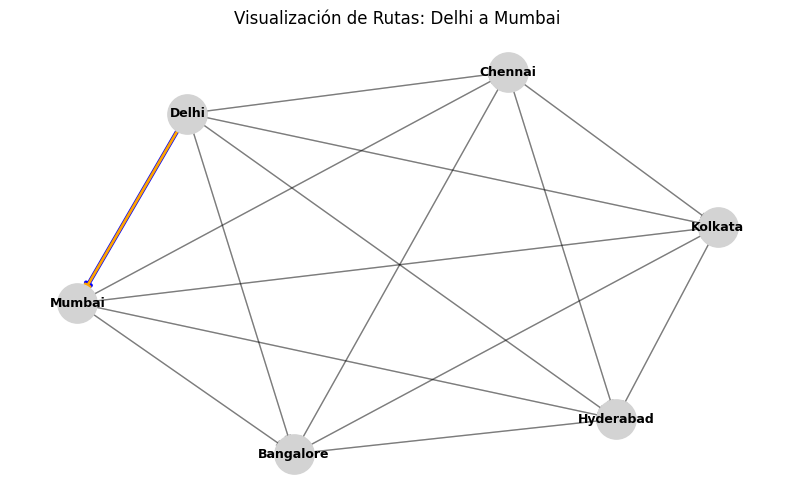

Nota: Ambos algoritmos encontraron la misma ruta.




Benchmark: origen: Kolkata a destino: Bangalore


,Métrica,BFS,UCS
0,Ruta,"[Kolkata, Bangalore]","[Kolkata, Hyderabad, Bangalore]"
1,Escalas,1,2
2,Costo Total (P*D),9655.00,6701.00
3,Nodos Visitados,5,3
4,Tiempo Ejecución,0.0383 ms,0.0533 ms


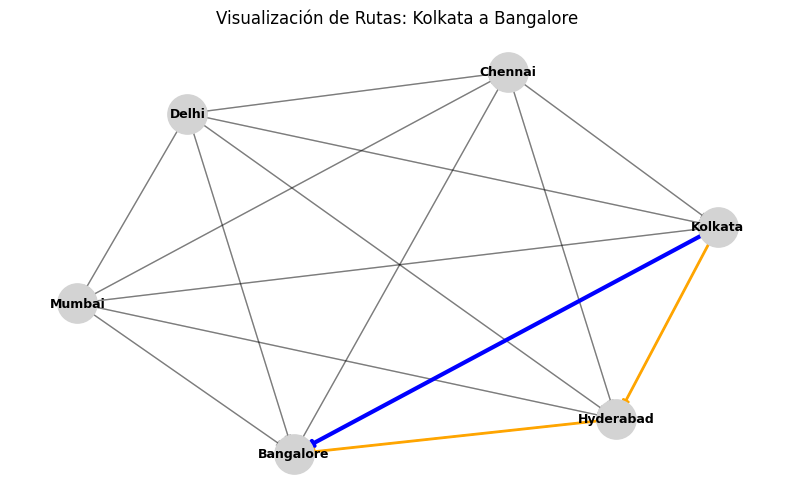

Nota: Los Algoritmos encontraron rutas distintas.




Benchmark: origen: Mumbai a destino: Hyderabad


,Métrica,BFS,UCS
0,Ruta,"[Mumbai, Hyderabad]","[Mumbai, Hyderabad]"
1,Escalas,1,1
2,Costo Total (P*D),2470.00,2470.00
3,Nodos Visitados,1,1
4,Tiempo Ejecución,0.0299 ms,0.0632 ms


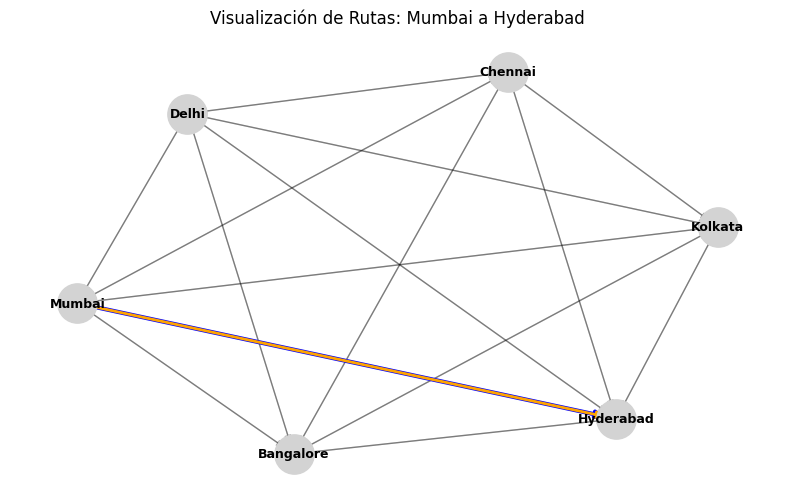

Nota: Ambos algoritmos encontraron la misma ruta.






In [38]:
pruebas = [("Delhi", "Mumbai"), ("Kolkata", "Bangalore"), ("Mumbai", "Hyderabad")]

for i, j in pruebas:
    ejecutar_benchmark(g1.list_aeropuertos, i, j)
    print("\n")

### Interpretacion de resultados
El benchmarks confirma que el sistema distingue con éxito entre la cantidad mínima de nodos a visitar (la ruta más recta) y el ahorro económico (la ruta más económica en Precio  X Duración). Gracias a que BFS siempre encuentra la ruta con menos escalas, y UCS es capaz de identificar rutas con escalas adicionales que resultan más baratas al optimizar la métrica de Price X Duration. En casos de alta demanda como Delhi-Mumbai, ambos algoritmos convergen en la misma solución, demostrando que la ruta más corta es también la más eficiente. También podemos apreciar como el tiempo de ejecución BFS, es consistentemente más rápido que UCS, al tener que recorrer menos nodos, siendo bastante óptimo para aplicaciones en tiempo real.

# Despliegue

In [39]:
def menu_interactivo(grafo_objeto, lista_vuelos_ponderada):
    aeropuertos = sorted(list(lista_vuelos_ponderada.keys()))
    mapa_aeropuertos = {i + 1: aero for i, aero in enumerate(aeropuertos)}

    while True:
        print("SISTEMA DE BÚSQUEDA DE VUELOS")

        # Opcion prioridad
        print("\n¿Qué prioridad tiene para su viaje?")
        print("1. Menos escalas (Ruta más corta)")
        print("2. Mejor relación Tiempo x Precio (Más económico)")

        opcion_algoritmo = input("\nSeleccione una opción (1 o 2): ")

        if opcion_algoritmo not in ['1', '2']:
            print("Opción no válida. Intente de nuevo.")
            continue
        print("\n")

        # lista aeropuertos
        print("Aeropuertos Disponibles")
        for id_aero, nombre in mapa_aeropuertos.items():
            print(f"{id_aero:2}. {nombre}")

        try:
            # Origen y Destino
            idx_origen = int(input("\nIngrese el NÚMERO del aeropuerto de ORIGEN: "))
            idx_destino = int(input("Ingrese el NÚMERO del aeropuerto de DESTINO: "))

            origen = mapa_aeropuertos.get(idx_origen)
            destino = mapa_aeropuertos.get(idx_destino)

            if not origen or not destino:
                print("Error: Uno de los números de aeropuerto no existe.")
                continue
            print("\n")

            if opcion_algoritmo == '1':
                # BFS
                ruta, saltos,_ = Algoritmos.bfs(lista_vuelos_ponderada, origen, destino)
                if ruta:
                    print(f"Ruta encontrada con el menor número de escalas")
                    print(f"Camino: {' -> '.join(ruta)}")
                    print(f"Total de escalas: {saltos}")
                else:
                    print("No se encontró una ruta disponible.")

            else:
                # UCS
                ruta, costo,_ = Algoritmos.ucs(lista_vuelos_ponderada, origen, destino)
                if ruta:
                    print(f"Ruta encontrada con el mejor Precio X Duracion")
                    print(f"Camino: {' -> '.join(ruta)}")
                    print(f"Costo total (P*D): {costo}")
                else:
                    print("No se encontró una ruta disponible.")

        except ValueError:
            print("Error: Por favor, ingrese solo números.")

        # bucle
        continuar = input("\n¿Desea realizar otra consulta? (s/n): ").lower()
        if continuar != 's':
            print("Gracias por usar nuestro sistema de vuelos")
            break

menu_interactivo(grafo, g1.list_aeropuertos)

SISTEMA DE BÚSQUEDA DE VUELOS

¿Qué prioridad tiene para su viaje?
1. Menos escalas (Ruta más corta)
2. Mejor relación Tiempo x Precio (Más económico)


Aeropuertos Disponibles
 1. Bangalore
 2. Chennai
 3. Delhi
 4. Hyderabad
 5. Kolkata
 6. Mumbai


Ruta encontrada con el mejor Precio X Duracion
Camino: Bangalore -> Hyderabad
Costo total (P*D): 1714.0
SISTEMA DE BÚSQUEDA DE VUELOS

¿Qué prioridad tiene para su viaje?
1. Menos escalas (Ruta más corta)
2. Mejor relación Tiempo x Precio (Más económico)


Aeropuertos Disponibles
 1. Bangalore
 2. Chennai
 3. Delhi
 4. Hyderabad
 5. Kolkata
 6. Mumbai


Ruta encontrada con el menor número de escalas
Camino: Chennai -> Delhi
Total de escalas: 1
Gracias por usar nuestro sistema de vuelos


# Referencias
- dataset de Kaggle por parte de rohitgrewal: https://www.kaggle.com/datasets/rohitgrewal/airlines-flights-data?resource=download
- BFS: https://es.wikipedia.org/wiki/B%C3%BAsqueda_en_anchura
- UCS: https://medium.com/@dipalimajet/understanding-hintons-capsule-networks-c2b17cd358d7


# Extra
Code in COLAB: https://colab.research.google.com/drive/1Qv-UqfvOENwvADeQ9Z0gnh9kX9Vpj_Qq?usp=sharing